# Milestone 2: 
### Project: `Forecasting Air Quality Using Historical Pollution Data` 
### Task: `ML Model Training & Evaluation with 4 different algorithms`

## Import All Required Libraries

In [4]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Time Series Models
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# For Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# For XGBoost
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')


# Load the dataset

In [5]:
air_aware_data = pd.read_csv(r"air_quality_data.csv")
print(air_aware_data.columns)
air_aware_data.head()

# Drop duplicates
air_aware_data.drop_duplicates(inplace=True)

pollutant_cols = ['AQI', 'PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']

# covert columns to numeric, coercing errors to NaN
for col in pollutant_cols:
    air_aware_data[col] = pd.to_numeric(air_aware_data[col] ,errors = 'coerce')

# Fill missing numeric values with median
for col in pollutant_cols:
    median_val = air_aware_data[col].median()
    air_aware_data[col].fillna(median_val)

# remove negative values if any
for col in pollutant_cols:
    air_aware_data = air_aware_data[air_aware_data[col] >= 0]

Index(['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


# Feature Scaling

In [6]:
# Scale all numeric pollutant columns between 0 and 1
#simplest way to bring all features into the same scale (0–1)
scaler = MinMaxScaler()
air_aware_data[pollutant_cols] = scaler.fit_transform(air_aware_data[pollutant_cols])

print("Scaled data sample:\n", air_aware_data.head())

Scaled data sample:
            City        Date     PM2.5      PM10     NO       NO2    NOx  NH3  \
1595  Ahmedabad  2019-05-15  0.043051  0.144270  15.08  0.306924  58.72  NaN   
1596  Ahmedabad  2019-05-16  0.038929  0.137082  14.67  0.287414  55.61  NaN   
1597  Ahmedabad  2019-05-17  0.040668  0.153311  18.02  0.279841  58.41  NaN   
1598  Ahmedabad  2019-05-18  0.039090  0.163037  13.27  0.271259  51.83  NaN   
1599  Ahmedabad  2019-05-19  0.038607  0.131664  34.56  0.248431  69.77  NaN   

            CO       SO2        O3  Benzene  Toluene  Xylene       AQI  \
1595  0.162220  0.876014  0.187102    16.44    85.54   14.19  0.194182   
1596  0.157810  0.490407  0.201187    15.55    83.89   13.15  0.229818   
1597  0.193847  0.528511  0.151249    15.88    83.83   13.34  0.248727   
1598  0.142750  0.476434  0.163782    15.93    82.73   13.44  0.250909   
1599  0.371773  0.434729  0.143334    15.53    84.17   13.19  0.387636   

     AQI_Bucket  
1595       Poor  
1596  Very Poor  

In [7]:
# Features and target
X = air_aware_data[['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']]
y = air_aware_data['AQI']

print("Feature sample:\n", X.head())
print("Target sample:\n", y.head())

Feature sample:
          PM2.5      PM10        O3       NO2       SO2        CO
1595  0.043051  0.144270  0.187102  0.306924  0.876014  0.162220
1596  0.038929  0.137082  0.201187  0.287414  0.490407  0.157810
1597  0.040668  0.153311  0.151249  0.279841  0.528511  0.193847
1598  0.039090  0.163037  0.163782  0.271259  0.476434  0.142750
1599  0.038607  0.131664  0.143334  0.248431  0.434729  0.371773
Target sample:
 1595    0.194182
1596    0.229818
1597    0.248727
1598    0.250909
1599    0.387636
Name: AQI, dtype: float64


In [72]:
# Load your cleaned dataset
air_aware_data= pd.read_csv("cleaned_air_quality_data.csv")

air_aware_data.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2019-05-15,0.043051,0.144270,15.08,0.306924,58.72,NaN,0.162220,0.876014,0.187102,16.44,85.54,14.19,0.194182,Poor
1,Ahmedabad,2019-05-16,0.038929,0.137082,14.67,0.287414,55.61,NaN,0.157810,0.490407,0.201187,15.55,83.89,13.15,0.229818,Very Poor
2,Ahmedabad,2019-05-17,0.040668,0.153311,18.02,0.279841,58.41,NaN,0.193847,0.528511,0.151249,15.88,83.83,13.34,0.248727,Very Poor
3,Ahmedabad,2019-05-18,0.039090,0.163037,13.27,0.271259,51.83,NaN,0.142750,0.476434,0.163782,15.93,82.73,13.44,0.250909,Very Poor
4,Ahmedabad,2019-05-19,0.038607,0.131664,34.56,0.248431,69.77,NaN,0.371773,0.434729,0.143334,15.53,84.17,13.19,0.387636,Severe


## Explore the data

In [75]:
# Basic stats
print(air_aware_data.describe())

# Check for missing values
print(air_aware_data.isnull().sum())

# Handle missing data if any
air_aware_data = air_aware_data.fillna(method='ffill')

              PM2.5          PM10            NO           NO2           NOx  \
count  16010.000000  16010.000000  16010.000000  16010.000000  16010.000000   
mean       0.065841      0.138708     18.127694      0.104950     33.852753   
std        0.059984      0.104439     23.172225      0.082331     31.398005   
min        0.000000      0.000000      0.030000      0.000000      0.000000   
25%        0.028647      0.066617      5.100000      0.044861     13.980000   
50%        0.049223      0.112655     10.220000      0.086891     25.240000   
75%        0.080184      0.175298     20.975000      0.141940     42.660000   
max        1.000000      1.000000    270.090000      1.000000    293.100000   

                NH3            CO           SO2            O3       Benzene  \
count  15649.000000  16010.000000  16010.000000  16010.000000  16010.000000   
mean      20.855922      0.015436      0.068662      0.136281      3.406980   
std       17.145010      0.038176      0.072533    

## Splitting the data into train and test data 

In [74]:
from sklearn.preprocessing import StandardScaler
# Select features and target
X = air_aware_data[['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']]
y = air_aware_data['AQI']

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Scale features for models that need normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# BUILDING EACH MODEL

## Building ARIMA model

ARIMA -> MAE: 0.035191065637036854  RMSE: 0.051968176617714544


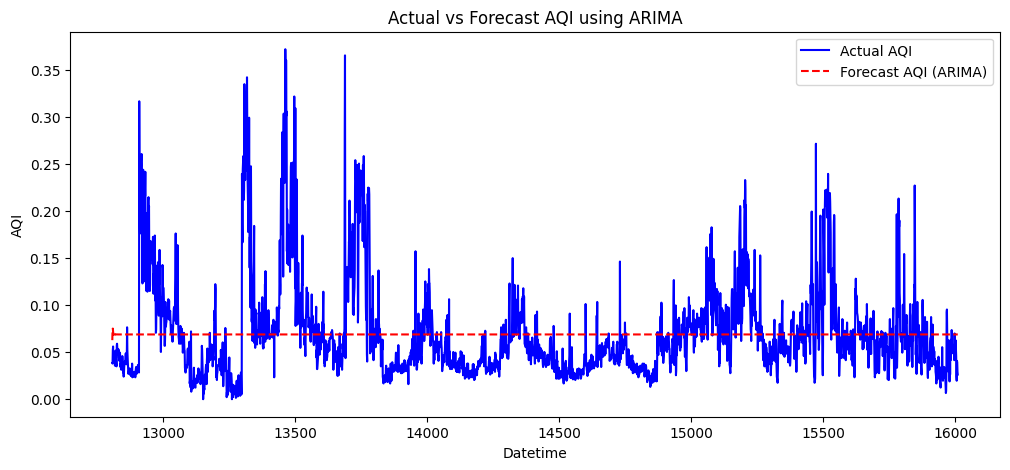

In [68]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepare AQI as time series
aqi_series = air_aware_data['AQI'].fillna(method='ffill')

# Split into train and test (80-20)
train_size = int(len(aqi_series) * 0.8)
train, test = aqi_series[:train_size], aqi_series[train_size:]

# Build and fit ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Forecast
forecast_arima = arima_fit.forecast(steps=len(test))

# Evaluate
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
mae_arima = mean_absolute_error(test, forecast_arima)
print("ARIMA -> MAE:", mae_arima, " RMSE:", rmse_arima)

import matplotlib.pyplot as plt

# Plot actual vs forecast
plt.figure(figsize=(12,5))
plt.plot(test.index, test, label="Actual AQI", color="blue")
plt.plot(test.index, forecast_arima, label="Forecast AQI (ARIMA)", color="red", linestyle="--")

plt.title("Actual vs Forecast AQI using ARIMA")
plt.xlabel("Datetime")
plt.ylabel("AQI")
plt.legend()
plt.show()

## Building Prophet Model

15:27:29 - cmdstanpy - INFO - Chain [1] start processing
15:27:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet -> MAE: 0.03590399955359212  RMSE: 0.05237560140536083


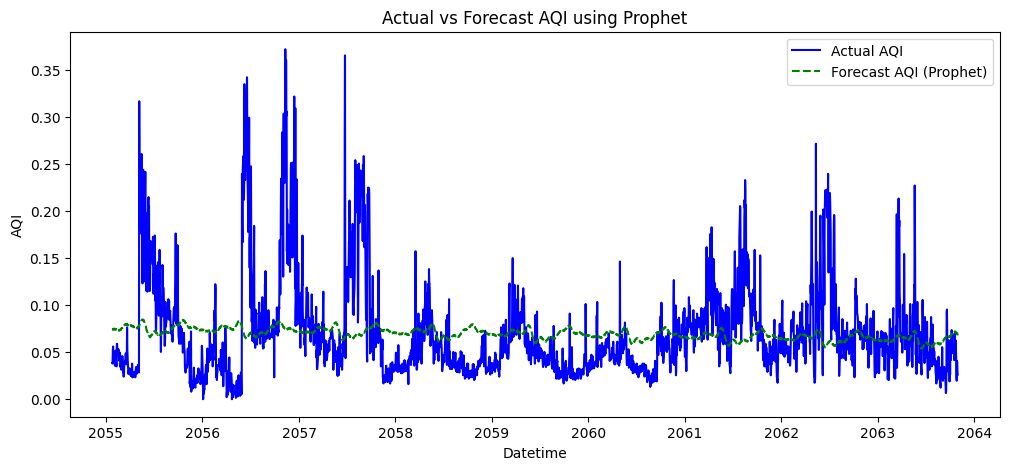

In [76]:
from prophet import Prophet

# Create Prophet-compatible dataframe
prophet_df = air_aware_data.copy()
prophet_df['ds'] = pd.date_range(start='2020-01-01', periods=len(prophet_df), freq='D')
prophet_df['y'] = prophet_df['AQI']

# Split train and test
train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

# Build Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Forecast for the test period
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast_prophet = prophet_model.predict(future)

# Extract forecasted values
y_pred_prophet = forecast_prophet['yhat'][-len(test_prophet):]

# Evaluate
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], y_pred_prophet))
mae_prophet = mean_absolute_error(test_prophet['y'], y_pred_prophet)
print("Prophet -> MAE:", mae_prophet, " RMSE:", rmse_prophet)


import matplotlib.pyplot as plt

# Plot actual vs forecast
plt.figure(figsize=(12,5))
plt.plot(test_prophet['ds'], test_prophet['y'], label="Actual AQI", color="blue")
plt.plot(test_prophet['ds'], y_pred_prophet, label="Forecast AQI (Prophet)", color="green", linestyle="--")

plt.title("Actual vs Forecast AQI using Prophet")
plt.xlabel("Datetime")
plt.ylabel("AQI")
plt.legend()
plt.show()


## Building XG Boost Model

XGBoost -> MAE: 0.011913808949482518  RMSE: 0.017782704150101535


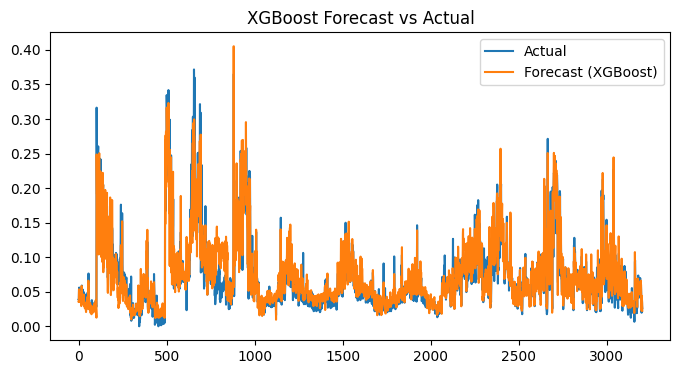

In [78]:
from xgboost import XGBRegressor

# Build and train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("XGBoost -> MAE:", mae_xgb, " RMSE:", rmse_xgb)
model_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=100)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
plt.figure(figsize=(8,4))
plt.plot(y_test.values, label="Actual")
plt.plot(pred_xgb, label="Forecast (XGBoost)")
plt.legend()
plt.title("XGBoost Forecast vs Actual")
plt.show()


## Building LSTM Model

In [79]:
# Load and Preprocess the Dataset
from tensorflow.keras.callbacks import EarlyStopping


In [80]:
# Example: Use your Air Quality DataFrame
df = air_aware_data.copy()

# Choose target variable (AQI or PM2.5)
target_col = 'AQI'

# Fill missing values
df = df.fillna(method='ffill')

# Normalize the target feature for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[target_col]])

# Create Time Series Sequences
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Use 24-hour window (or choose any lag)
time_steps = 24
X, y = create_sequences(scaled_data, time_steps)

# Split into train and test sets (80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

# Train the Model
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

y_pred = lstm_model.predict(X_test)

# Inverse transform to get original AQI values
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("LSTM -> MAE:", mae_lstm, " RMSE:", rmse_lstm)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 24, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0027 - val_loss: 8.5657e-04
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0020 - val_loss: 8.2820e-04
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0019 - val_loss: 7.6324e-04
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0017 - val_loss: 7.9665e-04
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0016 - val_loss: 7.3899e-04
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0016 - val_loss: 6.3441e-04
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0015 - val_loss: 5.9153e-04
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0015 - val_loss: 6.0387e-04
Epoch 9/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0014 - val_loss: 5.4651e-04
Epoch 10/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0014 - val_loss: 5.6114e-04
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LSTM -> MAE: 0.016004809238483002  RMSE: 0.02444

## Model Comparsion

In [84]:
# Dictionary of trained models
models = {
    'ARIMA': arima_model,
    'Prophet': prophet_model,
    'LSTM': lstm_model,
    'XGBoost': xgb_model
}

# Compare performance
results = pd.DataFrame({
    'Model': list(models.keys()),
    'MAE': [mae_arima, mae_prophet, mae_lstm, mae_xgb],
    'RMSE': [rmse_arima, rmse_prophet, rmse_lstm, rmse_xgb]
})

print("\n📊 Model Comparison:")
print(results)

# Find best model by lowest RMSE
best_model_name = results.loc[results['RMSE'].idxmin(), 'Model']
print(f"\n✅ Best Performing Model: {best_model_name}")

# Get the actual trained model object
best_model = models[best_model_name]

# Save the best model
import joblib
joblib.dump(best_model, f"best_{best_model_name.lower()}_model.joblib")

# Load later for inference
loaded_model = joblib.load(f"best_{best_model_name.lower()}_model.joblib")

# Example: make predictions (if applicable)
y_pred = loaded_model.predict(X_test_scaled)



📊 Model Comparison:
     Model       MAE      RMSE
0    ARIMA  0.035191  0.051968
1  Prophet  0.035904  0.052376
2     LSTM  0.016005  0.024442
3  XGBoost  0.013424  0.020149

✅ Best Performing Model: XGBoost


## Visualization of errors

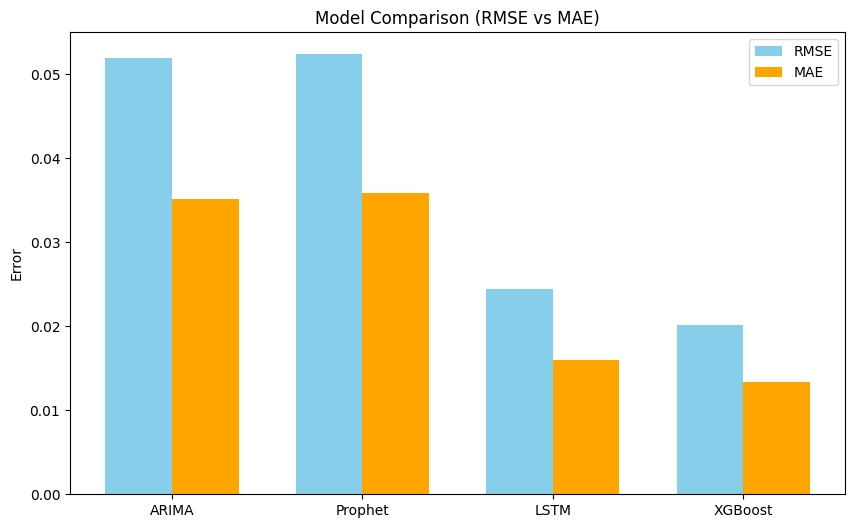

In [83]:
import numpy as np
import matplotlib.pyplot as plt

models = ['ARIMA', 'Prophet', 'LSTM', 'XGBoost']
rmses = [rmse_arima, rmse_prophet, rmse_lstm, rmse_xgb]
maes  = [mae_arima, mae_prophet, mae_lstm, mae_xgb]

x = np.arange(len(models))  # model positions
width = 0.35                # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width/2, rmses, width, label='RMSE', color='skyblue')
plt.bar(x + width/2, maes,  width, label='MAE',  color='orange')

plt.xticks(x, models)
plt.title("Model Comparison (RMSE vs MAE)")
plt.ylabel("Error")
plt.legend()
plt.show()


## Train per city

In [90]:
# ----- Imports -----
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import joblib

# ----- Load Your Dataset -----
Example: df = pd.read_csv("cleaned_air_quality_data.csv")
# Make sure it has columns: City, AQI, PM2.5, PM10, O3, NO2, SO2, CO
print("✅ Dataset Loaded")

# ----- Get Unique Cities -----
cities = df['City'].unique()
print(f"📍 Found {len(cities)} cities: {cities}")

city_models = []
print("\n🚀 Starting Per-City Training...\n")

# ----- Train & Evaluate Model for Each City -----
for city in cities:
    print(f"🏙️ Training model for: {city}")

    # Filter data for this city
    city_data = df[df['City'] == city].dropna()
    if city_data.shape[0] < 50:
        print(f"⚠️ Skipping {city} (not enough data)\n")
        continue

    # Features and target
    X = city_data[['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']]
    y = city_data['AQI']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Model
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"✅ {city} - MAE: {mae:.2f}, RMSE: {rmse:.2f}\n")

    # Save this model and its scaler
    joblib.dump(model, f"{city}_xgb_model.joblib")
    joblib.dump(scaler, f"{city}_scaler.joblib")

    city_models.append({
        'City': city,
        'Model': model,
        'Scaler': scaler,
        'MAE': mae,
        'RMSE': rmse
    })



✅ Dataset Loaded
📍 Found 24 cities: ['Ahmedabad' 'Aizawl' 'Amaravati' 'Amritsar' 'Bengaluru' 'Bhopal'
 'Brajrajnagar' 'Chandigarh' 'Chennai' 'Coimbatore' 'Delhi' 'Gurugram'
 'Guwahati' 'Hyderabad' 'Jaipur' 'Jorapokhar' 'Kochi' 'Kolkata' 'Mumbai'
 'Patna' 'Shillong' 'Talcher' 'Thiruvananthapuram' 'Visakhapatnam']

🚀 Starting Per-City Training...

🏙️ Training model for: Ahmedabad
⚠️ Skipping Ahmedabad (not enough data)

🏙️ Training model for: Aizawl
✅ Aizawl - MAE: 0.00, RMSE: 0.00

🏙️ Training model for: Amaravati
✅ Amaravati - MAE: 0.01, RMSE: 0.01

🏙️ Training model for: Amritsar
✅ Amritsar - MAE: 0.01, RMSE: 0.03

🏙️ Training model for: Bengaluru
✅ Bengaluru - MAE: 0.01, RMSE: 0.02

🏙️ Training model for: Bhopal
✅ Bhopal - MAE: 0.01, RMSE: 0.02

🏙️ Training model for: Brajrajnagar
✅ Brajrajnagar - MAE: 0.01, RMSE: 0.02

🏙️ Training model for: Chandigarh
✅ Chandigarh - MAE: 0.01, RMSE: 0.01

🏙️ Training model for: Chennai
✅ Chennai - MAE: 0.01, RMSE: 0.02

🏙️ Training model for: Coimb